#### Author: M Srinivasulu Reddy (Srini)
* This notebook is written and prepared as part of a take home project or assignment for one of the product based company

#### Assignment approach highlights
* There are beautiful ways to approach the BERT problem using Huggingface Transformers with native Pytorch and Tensorflow libraries but this assignment is done with the mix of Scikit-learn and native Tensorflow where I am comfortable. We also used Pytorch and Huggingface based code to resolve some of the problems for out existing clients.  
* Could not run this code in colab due to internet and session outages which frequently allowed to session disconnects consuming lot of time and also it is early to publish this code and run in Kaggle so could not utilize the GPU and decided to run this experiment in CPU laptop with 32 GB RAM.
* From assignment perspective, no need to chase metrics so bought in below strategies to complete the assignment and experimentation in local machine and in time.
    * Down sized the dataset to the least class sample which is neutral sentiment so this experiment can run in CPU in shorter time, this can also be considered as one of the steps to deal imbalanced datasets and here it is not the objective
    * Used small BERT to reduce the computational time
    * Numerous BERT experiments can be done but limited to this one due to time and computational complexity
* This notebook or codebase shows the apporaches towards the problem and also provides various tools and techniques further can be used to solve the problem or to take next level.
* Tried to provide functional explanation for most of the cells
* What further can be done to make this work more useful (I know this is not part of the assignment):
    * An Explainable AI to explain the classification (lime, shap, etc)
    * A simple deployment using flask and waitress, exposing it as rest API
    * An end to end AI, ML maintainable framework using mlflow, dvc, etc.

In [1]:
# Do all the required imports
import os
from collections import Counter

from nltk.corpus import stopwords

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Prepare the data path for data load
data_dir = "data"
file_name = "tripadvisor_hotel_reviews.csv"
data_path = os.path.join(os.curdir, data_dir, file_name)

print("data directory path {}" .format(data_path))

data directory path .\data\tripadvisor_hotel_reviews.csv


In [3]:
# Do the data load
data_frame = pd.read_csv(data_path)
# Check sample rows to get the sense of data
data_frame.sample(5)

,Review,Rating
6041,barcelo palace nightmare room ground floor bro...,1
11653,"loved wife stayed hotel week ago night, though...",5
8382,"stayed better, hotel location ok building work...",2
8515,great location poor customer service booked da...,1
225,"great seattle location great downtown hotel, p...",5


In [4]:
# Get the dataframe information and check for any null existence
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [5]:
# Check the % of counts in each class
counter = Counter(data_frame['Rating'])
class_percent = []
for c, co in counter.items():
    per = co / len(data_frame['Rating'])*100
    class_percent.append((c, co, per))

pd.DataFrame(class_percent, columns = ['rating', 'count', 'percentage']).sort_values('count', ascending=False)

,rating,count,percentage
3,5,9054,44.185252
0,4,6039,29.471475
2,3,2184,10.658338
1,2,1793,8.750183
4,1,1421,6.934752


#### Notes
* Build tf-idf vector to understand the feature importance of each class

In [6]:
# Construct tfidf vectorizer to transform text to feature vectors  
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
# Transform to term frequency inverse document frequency (tfidf) feature vector for complaint column / feature
features = tfidf.fit_transform(data_frame.Review)
# Frame the labels list from product id
labels = data_frame.Rating
# Check the shape after the transformation, it forms the sparse matrix for each row or complaint
features.shape

(20491, 80021)

#### Notes
* Used Chi-Square to get the feature importance of each class using uni, bi and tri grams
* Rating 1 and 2 reviews are negative related as expected 
* Rating 3 looks neutral
* Rating 4 and 5 are positively related

In [7]:
# Check the correlated words in each rating for uni, bi and tri grams
N = 10

for label in range(1, 6):
    features_chi2 = chi2(features, labels == label)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    #trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print("# '{}':".format(label))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))
    #print("  . Most correlated trigrams:\n       . {}".format('\n       . '.join(trigrams[-N:])))

# '1':
  . Most correlated unigrams:
       . refund
       . told
       . disgusting
       . filthy
       . rude
       . dump
       . horrible
       . terrible
       . worst
       . dirty
  . Most correlated bigrams:
       . avoid costs
       . hotel dirty
       . terrible hotel
       . extremely rude
       . rooms dirty
       . terrible experience
       . credit card
       . stay away
       . horrible experience
       . worst hotel
# '2':
  . Most correlated unigrams:
       . barely
       . tiny
       . okay
       . terrible
       . ok
       . rude
       . dirty
       . disappointing
       . poor
       . told
  . Most correlated bigrams:
       . room tiny
       . room smelled
       . noisy hear
       . poor quality
       . disappointing stayed
       . wo stay
       . biggest disappointment
       . rated stayed
       . service poor
       . did work
# '3':
  . Most correlated unigrams:
       . highly
       . fantastic
       . loved
       . bad


#### Notes
* Seggregate rating 1 and 2 as 0 as part of negative sentiment
* 3 as 1 as part of neutral sentiment
* Seggregate rating 4 and 5 as 2 as part of positive sentiment

In [8]:
# Set the sentiment 2 for positive, 1 for neutral and 0 for negative
def set_sentiment(rating):
    if rating >= 4:
        return 2
    elif rating == 3:
        return 1
    else:
        return 0

data_frame['Sentiment']= data_frame['Rating'].apply(set_sentiment)

# Check sample rows to get the sense of data
data_frame.sample(5)

,Review,Rating,Sentiment
7809,"phony fee visited seattle week, stayed days in...",1,0
9020,terrible location acceptable service hotel acc...,2,0
13684,excellent hotel stayed night whilst travelling...,5,2
10619,just ok tough review post generally francesco ...,2,0
4992,star hotel star value located half way duomo u...,4,2


In [9]:
# Check the % of counts in each class
counter = Counter(data_frame['Sentiment'])
class_percent = []
for c, co in counter.items():
    per = co / len(data_frame['Sentiment'])*100
    class_percent.append((c, co, per))

pd.DataFrame(class_percent, columns = ['sentiment', 'count', 'percentage']).sort_values('count', ascending=False)

,sentiment,count,percentage
0,2,15093,73.656727
1,0,3214,15.684935
2,1,2184,10.658338


#### Notes
* There are certain other ways like SMOTE and other to do the down sampling, a quick way of doing using native Pandas

In [10]:
# Down sizing the dataset as mentioned in the top assignment highlights
# Get the neutral sentiments
neutral_sent = data_frame[data_frame['Sentiment'] == 1]

# Get the positive sentiments equivalent to the count of neutral sentiment
positive_sent = data_frame[data_frame['Sentiment'] == 2]
positive_sent = positive_sent.sample(len(neutral_sent))

# Get the negative sentiments equivalent to the count of neutral sentiment
negative_sent = data_frame[data_frame['Sentiment'] == 0]
negative_sent = negative_sent.sample(len(neutral_sent))

# Concatenate neutral, positive and negative dataframes to down sample dataset
df_down_sample = pd.concat([neutral_sent, positive_sent, negative_sent])

# Check the % of counts in each class
counter = Counter(df_down_sample['Sentiment'])
class_percent = []
for c, co in counter.items():
    per = co / len(df_down_sample['Sentiment'])*100
    class_percent.append((c, co, per))

pd.DataFrame(class_percent, columns = ['sentiment', 'count', 'percentage']).sort_values('count', ascending=False)

,sentiment,count,percentage
0,1,2184,33.333333
1,2,2184,33.333333
2,0,2184,33.333333


#### Notes:
* From high level overview, the data mostly looks clean but just adding over one pre process function to clean few of them incase the relevant data or words exist in the dataset

In [11]:
# Put all the clean-up code in one function and execute them together and store it as a new column
def pre_process():
    stop_words = stopwords.words('english')
    
    # convert to lower case
    df_down_sample['Review_Clean'] = df_down_sample['Review'].apply(lambda x: ' '.join([i.lower() for i in x.split()]))
    # remove punctuation
    df_down_sample['Review_Clean'] = df_down_sample['Review_Clean'].str.replace(r'[^\w\s]', "")
    # remove masked characters like xx
    df_down_sample['Review_Clean'] = df_down_sample['Review_Clean'].str.replace(r"xx+\s", "")
    # remove stop words
    df_down_sample['Review_Clean'] = df_down_sample['Review_Clean'].apply(lambda x: ' '.join([i for i in x.split() if i not in stop_words]))

pre_process()

C:\Users\mommasani.srinivasul\Anaconda3\envs\bert_exp\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\mommasani.srinivasul\Anaconda3\envs\bert_exp\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


In [12]:
# One final sanity check before doing the train and test data splits
df_down_sample.sample(5)

,Review,Rating,Sentiment,Review_Clean
12910,"not going hotel rated 4* real stretch, pro bea...",3,1,going hotel rated 4 real stretch pro beach gre...
20179,funky prob wouldnt stay location ok. not far c...,3,1,funky prob wouldnt stay location ok far city c...
3468,bit worn amenities pictures description web si...,4,2,bit worn amenities pictures description web si...
15132,not convinced marco polo stayed marco polo 12/...,3,1,convinced marco polo stayed marco polo 129 179...
9867,londra good value hotel good value overall.buf...,4,2,londra good value hotel good value overallbuff...


In [13]:
# Split the dataset into train and test set using sklearn's stratify parameter, also shuffle the dataset during the split
X_train, X_test, y_train, y_test = train_test_split(df_down_sample['Review_Clean'],
                                                    df_down_sample['Sentiment'], 
                                                    stratify=df_down_sample['Sentiment'],
                                                    test_size=0.10, 
                                                    random_state=42,
                                                    shuffle=True)

print('length of train classes --> {}' .format(len(pd.DataFrame(y_train)['Sentiment'].unique())))
print('length of test classes --> {}' .format(len(pd.DataFrame(y_test)['Sentiment'].unique())))
print('missing groups any in between train and test classes --> {}' 
      .format(set(pd.DataFrame(y_train)['Sentiment'].unique())-set(pd.DataFrame(y_test)['Sentiment'].unique())))

length of train classes --> 3
length of test classes --> 3
missing groups any in between train and test classes --> set()


In [14]:
# Take a look how the train and test splits look
print("train data split \n{}" .format(y_train.value_counts()))
print("\n")
print("test data split \n{}" .format(y_test.value_counts()))

train data split 
0    1966
1    1965
2    1965
Name: Sentiment, dtype: int64


test data split 
2    219
1    219
0    218
Name: Sentiment, dtype: int64


In [15]:
# Define the bert pre-process model
pre_process_model = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_preprocess = hub.KerasLayer(pre_process_model)
# Define the bert encoder model
encoder_model = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
bert_encoder = hub.KerasLayer(encoder_model)

#### Notes:
* This BERT preprocessor is limited to 128 sequence length, rest of the words will be truncated
* Provides numerical representation of the words
* Provides the mask for the sentence, 1 representing words of the sentence and 0 as the padding 
* Represents single or multiple sentence inputs

In [16]:
# Test a sentence with bert pre-process model
text_test = ['the stay in this hotel is so wonderful', 'beautiful run rise can be seen from mountain villa']
text_preprocessed = bert_preprocess(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][1, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][1, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][1, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (2, 128)
Word Ids   : [ 101 3376 2448 4125 2064 2022 2464 2013 3137 6992  102    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
# Test sample bert embeddings
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

sample_embeddings = get_sentence_embeding(['the stay in this hotel is so wonderful',
                                           'beautiful run rise can be seen from mountain villa',
                                           'rude, bad and pathetic'])

print('similarity between sentence 1 and 2 {}' .format(cosine_similarity([sample_embeddings[0]],[sample_embeddings[1]])))
print('similarity between sentence 2 and 3 {}' .format(cosine_similarity([sample_embeddings[1]],[sample_embeddings[2]])))
print('similarity between sentence 1 and 3 {}' .format(cosine_similarity([sample_embeddings[0]],[sample_embeddings[2]])))

similarity between sentence 1 and 2 [[0.8638673]]
similarity between sentence 2 and 3 [[0.6833092]]
similarity between sentence 1 and 3 [[0.71094036]]


#### Notes:
* Early Stopping can be considered as one of the parameter tuning to stop the training early if the performance of the model is not improvising
* This saves the computational time, hardware resources and leads to step ahead to other useful experimentations

In [18]:
# Define the early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=4, 
                                                  min_delta=0.0001,
                                                  verbose=1,
                                                  mode='auto')

#### Notes:
* To organize the model and log folders in a disciplined manner and to do the required sub-tasks
* This also maintains the readability and helps incase of large runs for log audits 
* This is not equivalent to MLOPs like mlflow, dvc, etc but provides a little organized manner

In [19]:
# Define the model checkpoint callback
run_index = 1
model_dir = "models"
model_name = "model.h5"

mod_dir = os.path.join(os.curdir, model_dir, "run_{:03d}".format(run_index), model_name)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(mod_dir, 
                                                monitor="val_loss",
                                                verbose=1,
                                                save_best_only=True,
                                                save_weights_only=False,
                                                mode="auto",
                                                save_freq="epoch")

In [20]:
# Define the tensorboard callback
run_logdir = os.path.join(os.curdir, "logs", "run_{:03d}".format(run_index))
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

#### Notes:
* Bert Layers
    * Place holder for the text input
    * BERT preprocess layer defined few cells above 
    * Inputting the text incoming from point 1 and get ready with encoding inputs
    * BERT encoding layer defined few cells above and get the encoding outputs
         * pooled_output represents embedding for the pre-processed sentence. For example: If the batch size is 64 then it outputs (64, 512) representing the embedding space.
         * For fine tuning we will use pooled_output
         * Some datasets works fine without trainable and some improvises with training the encoding BERT layer
* Network Layers
    * Starts input from poole_output from BERT layer
    * Dropout layer for fine tuning
    * Dense layer with size of 3 to get the outputs for the classifier layer

In [21]:
# Define model architecture
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(pre_process_model, name='pre_processing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(encoder_model, trainable=True, name='encoder')
outputs = encoder(encoder_inputs)

# Neural network layers
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(len(y_train.unique()), activation='softmax', name='classifier')(net)

model = tf.keras.Model(text_input, net)

#### Notes:
* Defined loss as 'sparse_categorical_crossentropy' for the class representations such as [0, 1, 2, 3] 
* Learning rate starting with 3e-5 as per the BERT recommendation
* Wanted to see the accuracy of training and validation datasets. We can also input more metrics like precision, recall, etc to see more metrics during the training phase

In [22]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
              metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 pre_processing (KerasLayer)    {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [23]:
# Define the epochs and batch size
epochs = 20
batch_size = 64

#### Notes:
* Input training dataset such as review and sentiment as the input to the model
* Input the epoch and batch size
* Using validation split of 10% from the training set to check the model peformance
* Input all the defined callbacks
* Shuffle the dataset during the training phase

In [24]:
# Fit the model to start training
history = model.fit(X_train, 
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb],
                    shuffle=True,
                    verbose=1)

Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 0.8985 - accuracy: 0.5548
Epoch 00001: val_loss improved from inf to 0.67683, saving model to .\models\run_001\model.h5
83/83 [==============================] - 694s 8s/step - loss: 0.8985 - accuracy: 0.5548 - val_loss: 0.6768 - val_accuracy: 0.6966
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.7107
Epoch 00002: val_loss improved from 0.67683 to 0.62744, saving model to .\models\run_001\model.h5
83/83 [==============================] - 620s 7s/step - loss: 0.6494 - accuracy: 0.7107 - val_loss: 0.6274 - val_accuracy: 0.7220
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.7644
Epoch 00003: val_loss did not improve from 0.62744
83/83 [==============================] - 628s 8s/step - loss: 0.5559 - accuracy: 0.7644 - val_loss: 0.7055 - val_accuracy: 0.6949
Epoch 4/20
83/83 [==============================] - ETA: 0s - loss: 0.4958 - accuracy

#### Notes:
* Model has started overfitting from the third epoch itself and we know the reasons
    * We just used portion of the dataset and it is very minimal, this is to reduce the time and computational complexity
* What further can be done
    * Use all the possible data from the datasets, if still not seeing performance improvement then we can use data augmentation techniques, etc.
    * Use class balancing for imbalanced datasets
    * Tune the dropout parameter
    * Tune the learning rate
    * Check last few cells at end of this notebook for auto hyper-parameter tuning techniques
    * Try with bert models fine tuned for the sentiment analysis and recognition which can provide more value add
    * Try with bert base, large, albert, robert, etc to solve the training issues. There will be always trade off between time, computational and quality complexities. 

In [25]:
# This accuracy is from the last model checkpoint after early stopping
accr = model.evaluate(X_test, 
                      y_test,
                      batch_size=batch_size, 
                      verbose=1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

11/11 [==============================] - 22s 2s/step - loss: 0.6910 - accuracy: 0.7546
Test set
  Loss: 0.691
  Accuracy: 0.755


In [26]:
# Turn on this for adhoc testing 
"""
run_index = 1
model_dir = "models"
model_name = "model.h5"
mod_dir = os.path.join(os.curdir, model_dir, "run_{:03d}".format(run_index), model_name)
mod_dir
"""

'.\\models\\run_001\\model.h5'

In [27]:
# This accuracy is from the the best model saved from model checkpoint
loaded_model = load_model(mod_dir, custom_objects={'KerasLayer':hub.KerasLayer})
accr = loaded_model.evaluate(X_test, 
                             y_test,
                             batch_size=batch_size, 
                             verbose=1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

11/11 [==============================] - 22s 2s/step - loss: 0.5845 - accuracy: 0.7500
Test set
  Loss: 0.584
  Accuracy: 0.750


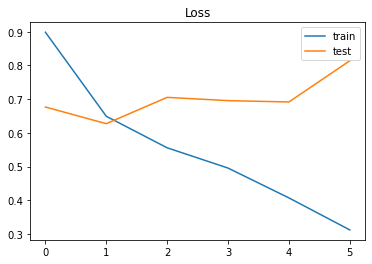

In [28]:
# Plot the validation loss graphs
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

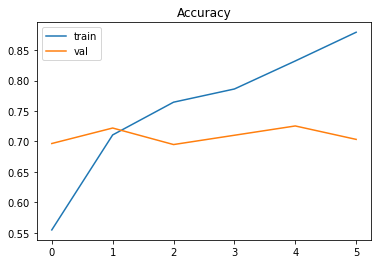

In [29]:
# Plot the accuracy graphs
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show();

In [30]:
# Get the encoded labels
labels = list(y_test.unique())
labels = list(map(str, labels))
print('labels {}' .format(labels))

labels ['2', '0', '1']


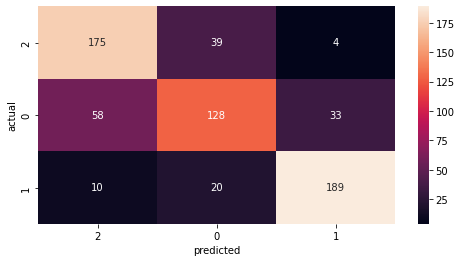

In [31]:
# Print the heat map for confusion matrix
y_pred = loaded_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=labels, yticklabels=labels)
plt.ylabel('actual')
plt.xlabel('predicted')
plt.show()

In [32]:
# Other way to get accuracy score
accur_score = accuracy_score(y_test, y_pred.argmax(axis=1))
print('overall accuracy score --> {}' .format(accur_score))

overall accuracy score --> 0.75


#### Points to remember for classification report
* Precision and Recall calculation for each class in multiclass classification
    * precision = diag(mat) / colsums(mat) --> actual class classified as actual / actual class classified as actual + other class(s) classified to this actual class 
    * recall = diag(mat) / rowsums(mat) --> actual class classified as actual / actual class classified as actual + actual classified to other class(s)
* Points to recall before deciding the model and pushing it to production
    * Complete details available in below links:
    * https://medium.com/usf-msds/choosing-the-right-metric-for-evaluating-machine-learning-models-part-2-86d5649a5428
    * https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28
    * Some quick points to refresh
        * High precision + High recall: The class is perfectly handled by the model
        * High precision + Low recall:  The model can’t detect the class well but is highly trustable when it does
        * Low precision  + High recall: The class is well detected but the model also include points of other classes in it
        * Low precision  + Low recall:  The class is poorly handled by the model

In [33]:
# Classification report of the model performance
print(classification_report(y_test, 
                            y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76       218
           1       0.68      0.58      0.63       219
           2       0.84      0.86      0.85       219

    accuracy                           0.75       656
   macro avg       0.75      0.75      0.75       656
weighted avg       0.75      0.75      0.75       656



#### Notes:
* Plot and work on AUC (Area Under Curve) and ROC (Receiver Operating Characteristics) for multi-class classification problem 

In [34]:
# Here's how to generate a prediction on individual examples and compare between actual and predicted labels
labels = ['0', '1', '2']

for i in range(600, 605):
    prediction = loaded_model.predict(np.array([X_test.iloc[i]]))
    predicted_label = labels[np.argmax(prediction)]
    print(X_test.iloc[i][:100], "...")
    print('actual label: {}'  .format(y_test.iloc[i]))
    print("predicted label: {}" .format(predicted_label))
    print("\n")

ok stay stayed week contacted hotel directly able free breakfast thrown package normally 10 euros pe ...
actual label: 1
predicted label: 1


right train station small rooms bit like ibis hotels small clean bathroom cross street train station ...
actual label: 1
predicted label: 1


hotel europa choice stayed hotel europa 8 days recent trip florence oct 2005 turned excellent choice ...
actual label: 2
predicted label: 2


great hotel good location stayed 2 nights march 2006 hotel modern style looks nice room small clean  ...
actual label: 2
predicted label: 2


potential great standard service lets badly stayed ocean sand affected lazy incompetent management s ...
actual label: 0
predicted label: 0




In [35]:
# Collect wrongly classified records for further analysis and remediations. 
wrong_preds = []

for i in range(len(X_test)):
    prediction = loaded_model.predict(np.array([X_test.iloc[i]]))
    predicted_label = labels[np.argmax(prediction)]
    actual_label = y_test.iloc[i]
    description = X_test.iloc[i]
    if(str(predicted_label).strip() != str(actual_label).strip()):
        wrong_preds.append((actual_label, predicted_label, description))
        #break

wrong_preds_df = pd.DataFrame(wrong_preds, columns =['Actual', 'Predicted', 'Description'])
wrong_preds_df.head()

,Actual,Predicted,Description
0,2,0,make returned week secrets excellence punta ca...
1,0,1,second time rio westin mar husband stayed west...
2,1,0,nothing fancy sheratonmarriott spent night ny ...
3,2,1,good breakfast stayed london nyc 2 nights shar...
4,1,0,pre post cruise stay stayed condado plaza 39 p...


In [36]:
# The number of wrong predictions detected here are equal to number of wrong predictions in confusion matrix
print('number of wrong predictions {}' .format(len(wrong_preds_df)))

number of wrong predictions 164


#### Notes:
* Sample code to predict the review rating for new or custom reviews
* Note, normally it has to go through preprocessing pipeline, here we consider the review is preprocessed

In [49]:
s_reviews = ['wonderful and beautiful stay hilton hotel',
             'average hotel nothing great',
             'worst experience never visit again']

label_map = {0:"negative", 1:"neutral", 2:"positive"}

for i in range(len(s_reviews)):
    print('review: {}' .format(s_reviews[i]))
    prediction = loaded_model.predict(np.array([s_reviews[i]]))
    print('predicted probabilities: {}' .format(prediction))
    predicted_label = labels[np.argmax(prediction)]
    print('predicted rating: {}\nmapped label: {}\n' .format(predicted_label, label_map.get(int(predicted_label))))

review: wonderful and beautiful stay hilton hotel
predicted probabilities: [[0.00266377 0.01707985 0.98025644]]
predicted rating: 2
mapped label: positive

review: average hotel nothing great
predicted probabilities: [[0.12683511 0.8396645  0.03350035]]
predicted rating: 1
mapped label: neutral

review: worst experience never visit again
predicted probabilities: [[0.9146548  0.03222778 0.05311745]]
predicted rating: 0
mapped label: negative



#### Auto Hyperparameter Tuning
* All below cells talks about the auto hyperparameter tuning steps, this is provided as part of the code completion but really not executed. This is a classical approach and there are several ways to do this such as AutoKeras, KerasTuner, etc.
    * A generic function to build the model
    * Defining the parameter distributins
    * An execution using gridsearchCV
    * An execution using randomizedsearchcv

In [ ]:
# Build the model
def build_model(drop_out=0.1, learning_rate=3e-5, trainable=True):
    # Define model architecture
    # Bert layers
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(pre_process_model, name='pre_processing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(encoder_model, trainable=trainable, name='encoder')
    outputs = encoder(encoder_inputs)

    # Neural network layers
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(drop_out)(net)
    net = tf.keras.layers.Dense(len(y_train.unique()), activation='softmax', name='classifier')(net)

    model = tf.keras.Model(text_input, net)
    
    model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

    return model

model = KerasClassifier(build_model)

In [ ]:
# Build the parameter distributions
param_distributions = {
    "drop_out": [0.1, 0.20, 0.30, 0.40, 0.50, 0.60],
    "learning_rate": [3e-5, 3e-6],
    "trainable": [True, False]
}

In [ ]:
# Build the GridSearchCV 
grid_search_cv = GridSearchCV(estimator=model, 
                              param_grid=param_distributions,
                              cv=3,
                              verbose=2)
# Fit the GridSearchCV 
grid_search_cv.fit(X_train, 
                   y_train, 
                   epochs=epochs, 
                   batch_size=batch_size,
                   validation_split=0.1,
                   callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb],
                   shuffle=True,
                   verbose=1)

In [ ]:
# Build the RandomSearchCV  
rnd_search_cv = RandomizedSearchCV(estimator=model, 
                                   param_distributions=param_distributions, 
                                   n_iter=10, 
                                   cv=3, 
                                   verbose=2)

# Fit the RandomSearchCV  
rnd_search_cv.fit(X_train, 
                  Y_train, 
                  epochs=epochs, 
                  batch_size=batch_size,
                  validation_split=0.1,
                  callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb],
                  shuffle=True,
                  verbose=1)